<a href="https://colab.research.google.com/github/tushant-akar/CS367-Artifical-Intelligence-Lab/blob/main/Binary_Bandit(Problem_2_Lab_7).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
from multiprocessing import Pool
from typing import Callable, Tuple
import matplotlib.pyplot as plt
from tqdm import tqdm

In [10]:
def binaryBanditA(action: int) -> int:
    p = [0.1, 0.2]
    return int(np.random.random() < p[action - 1])

def binaryBanditB(action: int) -> int:
    p = [0.8, 0.9]
    return int(np.random.random() < p[action - 1])

In [11]:
def epsilon_greedy(bandit_func: Callable[[int], int], epsilon: float, num_actions: int, num_iterations: int, alpha: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    Q = np.zeros(num_actions)
    N = np.zeros(num_actions)
    rewards = np.zeros(num_iterations)
    actions = np.zeros(num_iterations, dtype=int)

    for i in range(num_iterations):
        if np.random.random() < epsilon:
            action = np.random.randint(1, num_actions + 1)
        else:
            action = np.argmax(Q) + 1

        reward = bandit_func(action)

        N[action - 1] += 1
        Q[action - 1] += alpha * (reward - Q[action - 1])

        rewards[i] = reward
        actions[i] = action

        if i > 1000 and np.abs(np.mean(rewards[i-1000:i]) - np.mean(rewards[i-2000:i-1000])) < 1e-4:
            return Q, rewards[:i+1], actions[:i+1]

    return Q, rewards, actions

In [12]:
def run_experiment(params: Tuple[Callable[[int], int], float, int, int, float]) -> Tuple[np.ndarray, np.ndarray]:
    bandit_func, epsilon, num_actions, num_iterations, alpha = params
    Q, rewards, _ = epsilon_greedy(bandit_func, epsilon, num_actions, num_iterations, alpha)
    return Q, rewards

In [13]:
def pad_rewards(rewards_list: list, max_length: int) -> np.ndarray:
    return np.array([np.pad(r, (0, max_length - len(r)), 'constant', constant_values=np.nan) for r in rewards_list])

Processing Bandit A:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Processing Bandit B: 100%|██████████| 100/100 [00:04<00:00, 22.03it/s]



Results for Bandit A:
Average estimated action values: [0.0464186  0.17932718]
Overall average reward: 0.18299743098157736
Best action: 2
Final cumulative average reward: 0.14048238654395434

Results for Bandit B:
Average estimated action values: [0.71395367 0.8108217 ]
Overall average reward: 0.8814457075836358
Best action: 2
Final cumulative average reward: 0.5290301612064484


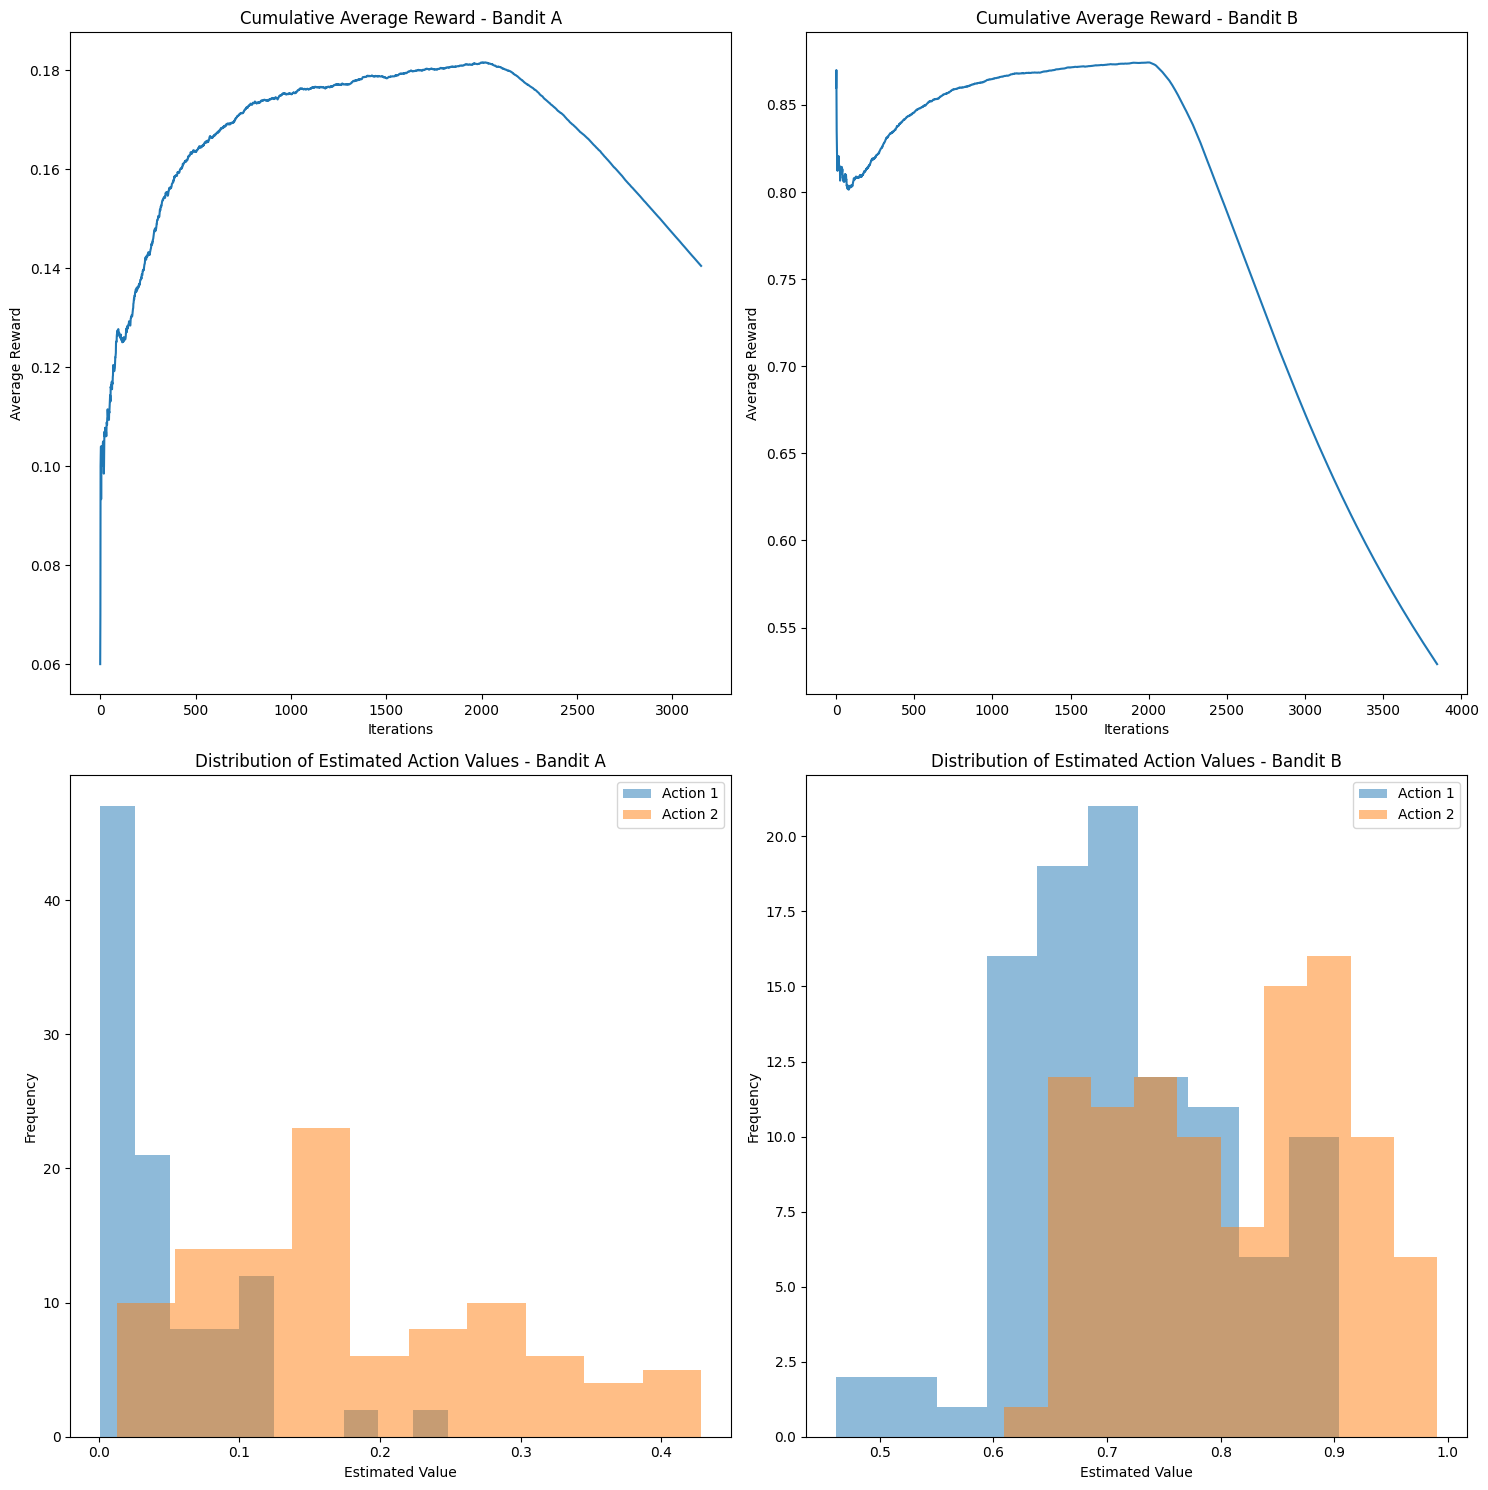

In [14]:
def plot_results(all_Q_A: np.ndarray, all_rewards_A: np.ndarray, all_Q_B: np.ndarray, all_rewards_B: np.ndarray):
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))

    for idx, (rewards, title) in enumerate([(all_rewards_A, 'Bandit A'), (all_rewards_B, 'Bandit B')]):
        cumulative_avg_reward = np.nanmean(np.nancumsum(rewards, axis=1) / np.arange(1, rewards.shape[1] + 1), axis=0)
        axes[0, idx].plot(cumulative_avg_reward)
        axes[0, idx].set_title(f'Cumulative Average Reward - {title}')
        axes[0, idx].set_xlabel('Iterations')
        axes[0, idx].set_ylabel('Average Reward')

    for idx, (Q, title) in enumerate([(all_Q_A, 'Bandit A'), (all_Q_B, 'Bandit B')]):
        axes[1, idx].hist(Q[:, 0], alpha=0.5, label='Action 1')
        axes[1, idx].hist(Q[:, 1], alpha=0.5, label='Action 2')
        axes[1, idx].set_title(f'Distribution of Estimated Action Values - {title}')
        axes[1, idx].set_xlabel('Estimated Value')
        axes[1, idx].set_ylabel('Frequency')
        axes[1, idx].legend()

    plt.tight_layout()
    plt.show()

def main():
    epsilon = 0.1
    num_actions = 2
    num_iterations = 10000
    num_experiments = 100
    alpha = 0.1

    params_A = [(binaryBanditA, epsilon, num_actions, num_iterations, alpha) for _ in range(num_experiments)]
    params_B = [(binaryBanditB, epsilon, num_actions, num_iterations, alpha) for _ in range(num_experiments)]

    with Pool() as pool:
        results_A = list(tqdm(pool.imap(run_experiment, params_A), total=num_experiments, desc="Processing Bandit A"))
        results_B = list(tqdm(pool.imap(run_experiment, params_B), total=num_experiments, desc="Processing Bandit B"))

    all_Q_A = np.array([result[0] for result in results_A])
    all_rewards_A = [result[1] for result in results_A]
    all_Q_B = np.array([result[0] for result in results_B])
    all_rewards_B = [result[1] for result in results_B]

    max_length_A = max(len(r) for r in all_rewards_A)
    max_length_B = max(len(r) for r in all_rewards_B)
    all_rewards_A = pad_rewards(all_rewards_A, max_length_A)
    all_rewards_B = pad_rewards(all_rewards_B, max_length_B)

    for name, Q, rewards in [("Bandit A", all_Q_A, all_rewards_A), ("Bandit B", all_Q_B, all_rewards_B)]:
        avg_Q = np.mean(Q, axis=0)
        avg_rewards = np.nanmean(rewards, axis=0)
        cumulative_avg_reward = np.nanmean(np.nancumsum(rewards, axis=1) / np.arange(1, rewards.shape[1] + 1), axis=0)

        print(f"\nResults for {name}:")
        print(f"Average estimated action values: {avg_Q}")
        print(f"Overall average reward: {np.nanmean(avg_rewards)}")
        print(f"Best action: {np.argmax(avg_Q) + 1}")
        print(f"Final cumulative average reward: {cumulative_avg_reward[-1]}")

    plot_results(all_Q_A, all_rewards_A, all_Q_B, all_rewards_B)

if __name__ == "__main__":
    main()